# De novo design

### Developers: Mat Bieniek, Ben Cree, Rachael Pirie, Josh Horton

* Add R-groups in user-defined positions
* Output ADMET properties
* Perform constrained optimisation
* Score poses
* Send output to free energy calculations

Open source, customisable, fast/easy to use.

In [1]:
import copy
import glob
import prody
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from rgroup import RMol, RList, build_molecules, fix_receptor, optimise_in_receptor, RGroups, sort_conformers, ic50

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [49]:
%cd /home/c0065492/rgroups/dat/bace_p2/19jan

/home/c0065492/rgroups/dat/bace_p2/19jan


In [3]:
prefix = 'lig_' #to extract experimental data from ligands.yml

In [4]:
!wget -nc https://files.rcsb.org/download/3IN4.pdb
pdb = '3IN4.pdb'

File ‘3IN4.pdb’ already there; not retrieving.



In [5]:
RMol.set_gnina(loc='/home/c0065492/software/gnina')

In [6]:
# load the complex with the ligand
sys = prody.parsePDB(pdb)
#sys = prody.parsePDB('jnk1/2gmx.pdb')

rec = sys.select('not (nucleic or hetatm) and not water')
#mol = sys.select('resname 19H and chain A')
mol = sys.select('resname 0X5')

prody.writePDB('rec.pdb', rec)
#prody.writePDB('lig.pdb', mol)

@> 3011 atoms and 1 coordinate set(s) were parsed in 0.04s.


'rec.pdb'

In [7]:
#!wget 'https://models.rcsb.org/v1/5nev/ligand?auth_seq_id=301&label_asym_id=E&encoding=sdf&filename=5nev_E_72L.sdf' -O lig.sdf
#!obabel jnk1/core.sdf -O jnk1/coreh.sdf -p 7
!obabel -isdf core.sdf -osdf -O coreh.sdf -p 7
#obabel gets protonation wrong
# ^manually modify the files if need be
%pwd

'/home/c0065492/rgroups/dat/bace_p2/test'

In [8]:
# load the ligand
# rdkit doesn't do a good job with protonation, 
#init_mol = Chem.MolFromPDBFile('lig.pdb', removeHs=False)
#init_mol = Chem.AddHs(init_mol, addCoords=True)

init_mol = Chem.SDMolSupplier('coreh.sdf', removeHs=False)[0]

# get the R group representation of the rdkit Mol
rinit_mol = RMol(init_mol)

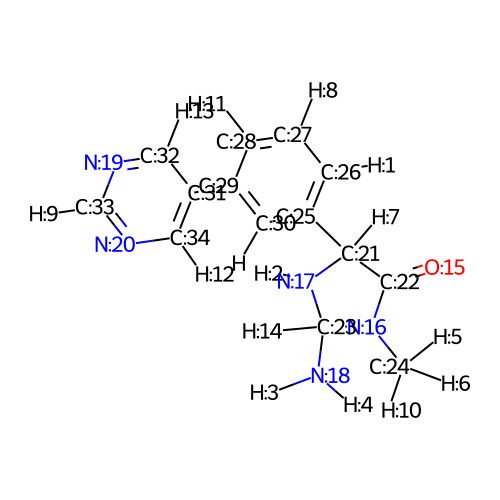

In [9]:
# select the atom to be replaced with the R group
rinit_mol.rep2D(idx=True, size=(500, 500))

In [10]:
glob.glob("*")

['scores_35.dat',
 'notebook_bace_p2.db',
 'best_conformers_38.sdf',
 '37',
 'scores_33.dat',
 'scores_34.dat',
 'ligands.yml',
 'best_conformers_36.sdf',
 'best_conformers_31.pdb',
 'convert.sh',
 'scores_31.dat',
 'optimised_coords_35.pdb',
 'best_conformers_38.pdb',
 '30',
 'optimised_coords_33.pdb',
 'optimised_coords_29.pdb',
 'scores_36.dat',
 'best_conformers_36.pdb',
 'scores_28.dat',
 'optimised_coords_39.pdb',
 '38',
 'best_conformers_30.pdb',
 'db.json',
 'rgroups_bace_p2.ipynb',
 'core.sdf',
 '33',
 'best_conformers_33.pdb',
 'optimised_coords_32.pdb',
 '36',
 'coreh2.sdf',
 'best_conformers_33.sdf',
 'best_conformers_34.sdf',
 'coreh.sdf',
 'optimised_coords_38.pdb',
 'optimised_coords_28.pdb',
 '31',
 'best_conformers_35.sdf',
 'scores_32.dat',
 'optimised_coords_37.pdb',
 '35',
 '34',
 '28',
 'out.png',
 'best_conformers_28.sdf',
 'best_conformers_31.sdf',
 '32',
 'rec.pdb',
 'deltaG2.png',
 'notebook_bacep2_12jan.db',
 'best_conformers_32.sdf',
 'best_conformers_39.pdb'

In [11]:
#remove 44 since all conformers clash with protein
ligand_ids = list(range(28,40))
ligand_ids

[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

In [12]:
#ligand_ids = ['13c', '13d', '13h', '17c', '17h']
# read the rgroups 1 by 1 in a loop
#ligand_idss that there is only one -r.mol in each dir
rgroups = [Chem.MolFromMolFile(glob.glob(f'{ligand_id}/*.mol')[0], removeHs=False) for ligand_id in ligand_ids]
rgroups

In [13]:
ligand_ids[0] #to check what rgroup is failing optimisation or clash with protein

28

In [14]:
# build a list of molecules
attachment_index = [7]
rmols = build_molecules(rinit_mol, attachment_index, rgroups)

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f204ab21d60> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f204ab21c40>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f204ab21e20> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f204ab21ee0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f204ab21c40> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f204ab21d60>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f204ab21e20> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f204ab21ee0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f204ab21d60> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f204ab21c40>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f204ab21e20> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f204ab21ee0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f204ab21d60> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f204ab21c40>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom o

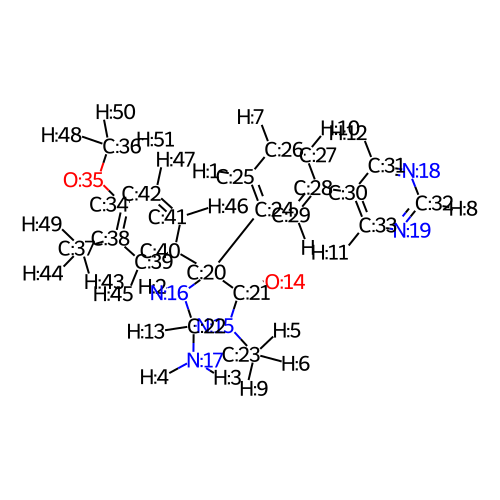

In [15]:
rmols[0].rep2D(idx=True, size=(500, 500))

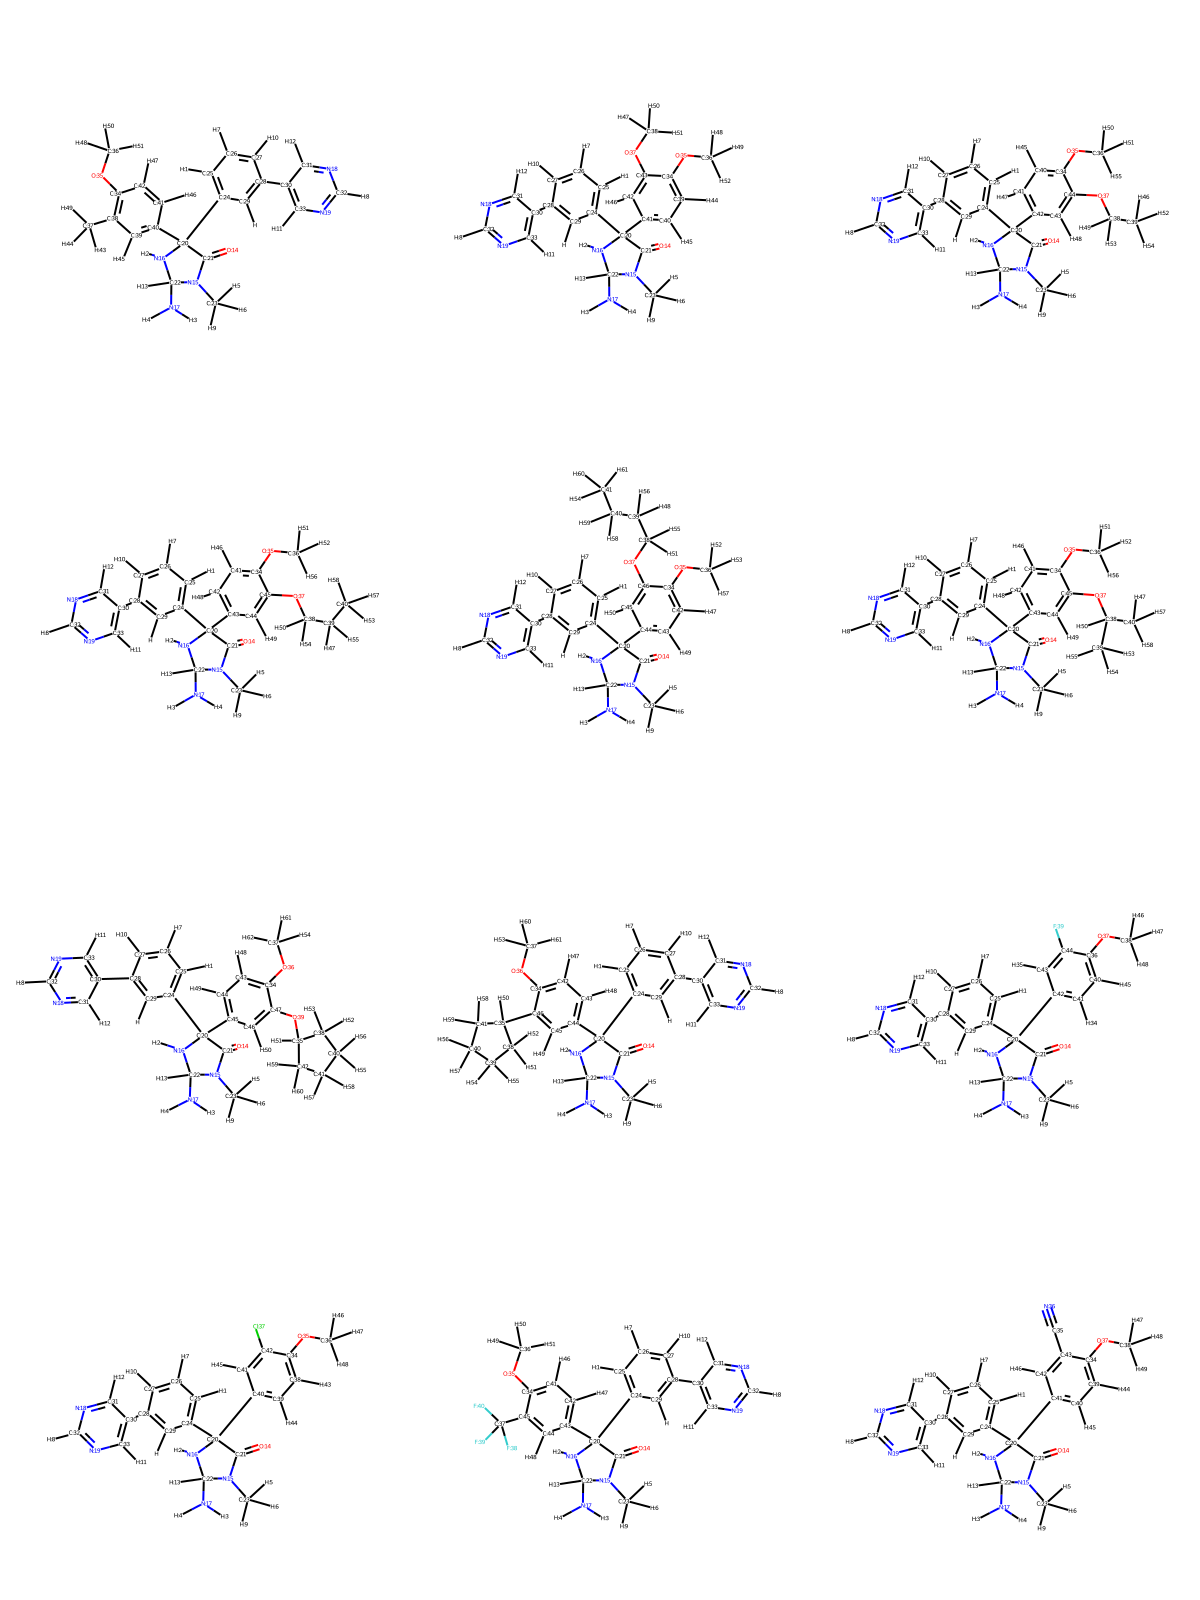

In [16]:
rmols.rep2D()

In [17]:
rmols[3].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [18]:
rmols.toxicity()

,MW,HBA,HBD,LogP,Pass_Ro5,has_pains,has_unwanted_subs,has_prob_fgs,synthetic_accessibility
0,389.185175,6,2,2.00812,True,False,False,False,7.847934
0,405.180090,7,2,1.70830,True,False,False,False,7.811504
0,419.195740,7,2,2.09840,True,False,False,False,8.001865
0,433.211390,7,2,2.48850,True,False,False,False,8.157196
0,447.227040,7,2,2.87860,True,False,False,False,8.279774
0,433.211390,7,2,2.48690,True,False,False,False,8.147031
0,459.227040,7,2,3.02110,True,False,False,False,8.309439
0,443.232125,6,2,3.35730,True,False,False,False,8.305711
0,393.160103,6,2,1.83880,True,False,False,False,7.394671
0,409.130553,6,2,2.35310,True,False,False,False,7.390546


In [19]:
rmols.generate_conformers(num_conf=200,
                         minimum_conf_rms=0.5,
                         )

RMol index 0
removed 186 duplicated conformations
RMol index 1
removed 184 duplicated conformations
RMol index 2
removed 163 duplicated conformations
RMol index 3
removed 102 duplicated conformations
RMol index 4
removed 54 duplicated conformations
RMol index 5
removed 87 duplicated conformations
RMol index 6
removed 71 duplicated conformations
RMol index 7
removed 114 duplicated conformations
RMol index 8
removed 195 duplicated conformations
RMol index 9
removed 196 duplicated conformations
RMol index 10
removed 186 duplicated conformations
RMol index 11
removed 193 duplicated conformations


In [20]:
#rmol.rep3D(template=True)

In [21]:
rmols.GetNumConformers()

[15, 17, 38, 99, 147, 114, 130, 87, 6, 5, 15, 8]

### Optimise conformers in context of protein

In [22]:
# fix the receptor file 
fix_receptor("rec.pdb", "rec_h.pdb")
# load back into prody
rec_fix = prody.parsePDB("rec_h.pdb")

@> 5753 atoms and 1 coordinate set(s) were parsed in 0.03s.


In [23]:
# filter by the protein clashes
rmols[2].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [24]:
rmols.removeConfsClashingWithProdyProt(rec_fix)

RMol index 0
Clash with the protein. Removing conformer id: 12
Clash with the protein. Removing conformer id: 0
RMol index 1
Clash with the protein. Removing conformer id: 0
RMol index 2
Clash with the protein. Removing conformer id: 33
Clash with the protein. Removing conformer id: 27
Clash with the protein. Removing conformer id: 23
Clash with the protein. Removing conformer id: 21
Clash with the protein. Removing conformer id: 16
Clash with the protein. Removing conformer id: 0
RMol index 3
Clash with the protein. Removing conformer id: 97
Clash with the protein. Removing conformer id: 94
Clash with the protein. Removing conformer id: 93
Clash with the protein. Removing conformer id: 92
Clash with the protein. Removing conformer id: 90
Clash with the protein. Removing conformer id: 88
Clash with the protein. Removing conformer id: 84
Clash with the protein. Removing conformer id: 83
Clash with the protein. Removing conformer id: 81
Clash with the protein. Removing conformer id: 79
C

In [25]:
rmols.GetNumConformers()

[13, 16, 32, 45, 35, 90, 42, 36, 5, 4, 12, 5]

In [26]:
rmols[2].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [27]:
# opt_mol, energies
energies = rmols.optimise_in_receptor(
    receptor_file="rec_h.pdb", 
    ligand_force_field="openff", 
    use_ani=True,
    sigma_scale_factor=0.8,
    relative_permittivity=4
)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: 3IN4Undefined chiral centers are:
 - Atom C (index 20)
 - Atom C (index 22)



RMol index 0


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 40)



using ani2x


Optimising conformer: 100%|█████████████████████| 13/13 [00:59<00:00,  4.61s/it]


RMol index 1


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: 3IN4Undefined chiral centers are:
 - Atom C (index 20)
 - Atom C (index 22)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 40)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 41)



using ani2x


Optimising conformer: 100%|█████████████████████| 16/16 [01:12<00:00,  4.55s/it]


RMol index 2


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: 3IN4Undefined chiral centers are:
 - Atom C (index 20)
 - Atom C (index 22)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 40)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 41)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 44)



using ani2x


Optimising conformer: 100%|█████████████████████| 32/32 [02:57<00:00,  5.54s/it]


RMol index 3


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: 3IN4Undefined chiral centers are:
 - Atom C (index 20)
 - Atom C (index 22)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 40)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 41)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 44)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (i

using ani2x


Optimising conformer: 100%|█████████████████████| 45/45 [04:06<00:00,  5.48s/it]
Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: 3IN4Undefined chiral centers are:
 - Atom C (index 20)
 - Atom C (index 22)



RMol index 4


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 40)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 41)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 44)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 47)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom

using ani2x


Optimising conformer: 100%|█████████████████████| 35/35 [03:33<00:00,  6.11s/it]
Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: 3IN4Undefined chiral centers are:
 - Atom C (index 20)
 - Atom C (index 22)



RMol index 5


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 40)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 41)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 44)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 47)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom

using ani2x


Optimising conformer: 100%|█████████████████████| 90/90 [09:31<00:00,  6.35s/it]


RMol index 6


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: 3IN4Undefined chiral centers are:
 - Atom C (index 20)
 - Atom C (index 22)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 40)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 41)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 44)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (i

using ani2x


Optimising conformer: 100%|█████████████████████| 42/42 [04:52<00:00,  6.97s/it]


RMol index 7


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: 3IN4Undefined chiral centers are:
 - Atom C (index 20)
 - Atom C (index 22)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 40)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 41)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 44)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (i

using ani2x


Optimising conformer: 100%|█████████████████████| 36/36 [04:26<00:00,  7.39s/it]


RMol index 8


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: 3IN4Undefined chiral centers are:
 - Atom C (index 20)
 - Atom C (index 22)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 40)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 41)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 44)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (i

using ani2x


Optimising conformer: 100%|███████████████████████| 5/5 [00:27<00:00,  5.57s/it]
Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: 3IN4Undefined chiral centers are:
 - Atom C (index 20)
 - Atom C (index 22)



RMol index 9


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 40)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 41)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 44)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 47)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom

using ani2x


Optimising conformer: 100%|███████████████████████| 4/4 [00:19<00:00,  4.81s/it]
Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: 3IN4Undefined chiral centers are:
 - Atom C (index 20)
 - Atom C (index 22)



RMol index 10


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 40)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 41)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 44)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 47)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom

using ani2x


Optimising conformer: 100%|█████████████████████| 12/12 [01:01<00:00,  5.11s/it]


RMol index 11


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. RDMol name: 3IN4Undefined chiral centers are:
 - Atom C (index 20)
 - Atom C (index 22)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 40)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 41)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 14)
 - Atom C (index 44)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (i

using ani2x


Optimising conformer: 100%|███████████████████████| 5/5 [00:26<00:00,  5.27s/it]


In [28]:
rmols[0].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [29]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("optimised_coords_" + str(ligand_ids[i]) + ".pdb")

In [30]:
final_energies = rmols.sort_conformers(energy_range=5)

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
RMol index 7
RMol index 8
RMol index 9
RMol index 10
RMol index 11


In [31]:
len(ligand_ids) == len(rmols) #check theyre equal or very bad and silent things happen

True

In [32]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("best_conformers_" + str(ligand_ids[i]) + ".pdb")

In [33]:
#RMol.set_gnina(loc='gnina')

In [34]:
CNNscores = rmols.gnina(receptor_file="rec_h.pdb") 

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
RMol index 7
RMol index 8
RMol index 9
RMol index 10
RMol index 11


In [35]:
rmols.discard_missing()

[]

In [36]:
import dill
dill.dump_session('notebook_bacep2_12jan.db')

In [37]:
ligand_id_idx = []
[ligand_id_idx.append(x) for x in CNNscores if x != 0]

'''
for i in range(len(CNNscores)):
    if len(CNNscores[i]) == 0:
        ligand_id_idx.append(i)
'''



'\nfor i in range(len(CNNscores)):\n    if len(CNNscores[i]) == 0:\n        ligand_id_idx.append(i)\n'

In [38]:
ic50_scores = []
for i in range(len(CNNscores)):
    ic50_scores.append([ic50(x) for x in CNNscores[i]])

In [39]:
for i in range(len(ic50_scores)):
    with open('scores_' + str(ligand_ids[i]) + '.dat', 'w') as f:
        for x in range(len(ic50_scores[i])):
            f.write(str(ic50_scores[i][x])+'\n')

In [40]:
lowest = []
for i in range(len(ic50_scores)):
    lowest.append(ic50_scores[i][0])

In [41]:
import yaml
with open("ligands.yml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
suffix = '_L'
experimental = []
for i in range(len(ligand_ids)):
    if data[prefix + str(ligand_ids[i])+suffix]['measurement']['unit'] == 'nM':
        print('found nM')
        experimental.append(data[prefix+ str(ligand_ids[i])+suffix]['measurement']['value'])
    elif data[prefix + str(ligand_ids[i])+suffix]['measurement']['unit'] == 'uM':
        experimental.append(1000*data[prefix+ str(ligand_ids[i])+suffix]['measurement']['value'])
    else:
        print('UNKNOWN UNIT - SKIPPING')
experimental 

[40.0, 90.0, 50.0, 50.0, 50.0, 60.0, 70.0, 120.0, 50.0, 36.0, 40.0, 150.0]

In [42]:
import dill
%cd ~/rgroups/dat/bace_p2/test
dill.load_session('notebook_bacep2_12jan.db')

/home/c0065492/rgroups/dat/bace_p2/test


In [43]:
import pandas as pd

name = [ligand_ids[i:i+1] for i in range(0, len(ligand_ids), 1)]
energies = [i[0] for i in final_energies]
cnn = [i[0] for i in CNNscores]
ic50 = [i[0] for i in ic50_scores]
expt = [i for i in experimental]
output = pd.DataFrame({'ID' : name, 'Final energies' : energies, 'Gnina score' : cnn, 'Gnina IC50 / nM' : ic50, 'Experimental IC50 / nM' : expt})
output

,ID,Final energies,Gnina score,Gnina IC50 / nM,Experimental IC50 / nM
0,[28],0.0,6.83226,147.143133,40.0
1,[29],0.0,6.81356,153.617255,90.0
2,[30],0.0,6.81294,153.836716,50.0
3,[31],0.0,6.84105,144.194933,50.0
4,[32],0.0,6.95206,111.670896,50.0
5,[33],0.0,7.02437,94.543135,60.0
6,[34],0.0,6.58294,261.252226,70.0
7,[35],0.0,6.85763,138.793779,120.0
8,[36],0.0,6.94352,113.888533,50.0
9,[37],0.0,6.97499,105.927812,36.0


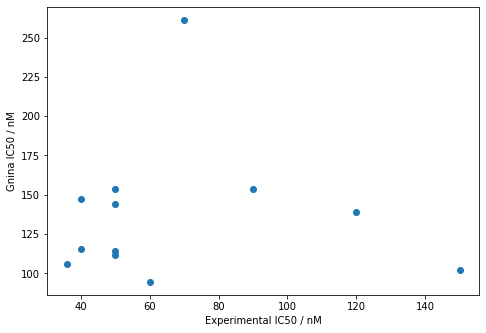

In [44]:
import matplotlib.pyplot as plt
import numpy as np
#ligands 27 & 28 have stereochem issues
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(experimental, lowest) #, color='black', marker='x')
ax.set_xlabel('Experimental IC50 / nM')
ax.set_ylabel('Gnina IC50 / nM')

x = np.linspace(0,25,25)
#ax.plot(x, x, color='black', linestyle='--')

plt.savefig('out.png', bbox_inches='tight')
plt.show()

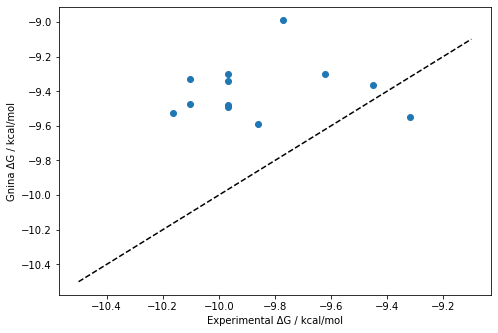

In [45]:
# convert nM to M
lowestinM = [ i * 1e-9 for i in lowest]
exptinM = [ i * 1e-9 for i in expt]

RT = 0.593 # kcal/mol

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# DG = RTln(K)
ax.scatter(RT*np.log(exptinM), RT*np.log(lowestinM)) #, color='black', marker='x')
ax.set_xlabel('Experimental \u0394G / kcal/mol')
ax.set_ylabel('Gnina \u0394G / kcal/mol')

x = np.linspace(-10.5,-9.1,10)
ax.plot(x, x, color='black', linestyle='--')
A = np.vstack([experimental, np.ones(len(experimental))]).T
m, c = np.linalg.lstsq(A, lowest, rcond=None)[0]

m = "{:.2f}".format(m)
r = "r^2 =" + str(m)
plt.annotate(r, (-10,-6))
plt.savefig('deltaG2.png', bbox_inches='tight')
plt.show()

In [46]:
import re
smina_affinities = []
with open('smina_scores.dat', 'r') as f:
    for line in f:
        affinity = re.findall(r'Affinity: (-\d+.\d+)', str(line))
        try:
            smina_affinities.append(float(affinity[0]))
        except:
            pass

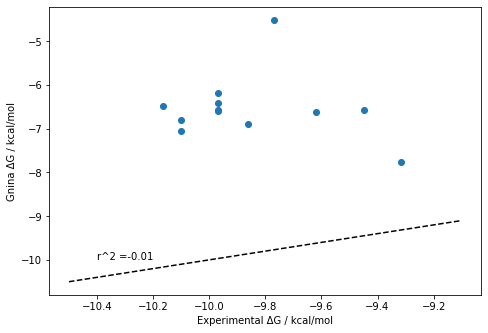

In [47]:
# convert nM to M
lowestinM = [ i * 1e-9 for i in lowest]
exptinM = [ i * 1e-9 for i in expt]

RT = 0.593 # kcal/mol

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# DG = RTln(K)
ax.scatter(RT*np.log(exptinM), smina_affinities) #, color='black', marker='x')
ax.set_xlabel('Experimental \u0394G / kcal/mol')
ax.set_ylabel('Gnina \u0394G / kcal/mol')

x = np.linspace(-10.5,-9.1,10)
ax.plot(x, x, color='black', linestyle='--')
A = np.vstack([experimental, np.ones(len(experimental))]).T
m, c = np.linalg.lstsq(A, lowest, rcond=None)[0]

m = "{:.2f}".format(m)
r = "r^2 =" + str(m)
plt.annotate(r, (-10.4,-10))
plt.savefig('deltaG2_smian.png', bbox_inches='tight')
plt.show()

In [48]:
len(smina_affinities)

12

In [50]:
import dill
dill.dump_session('rgroups_bace_p2_21jan.ipynb')